Text(0.5, 1.0, 'Hit Map Histogram')

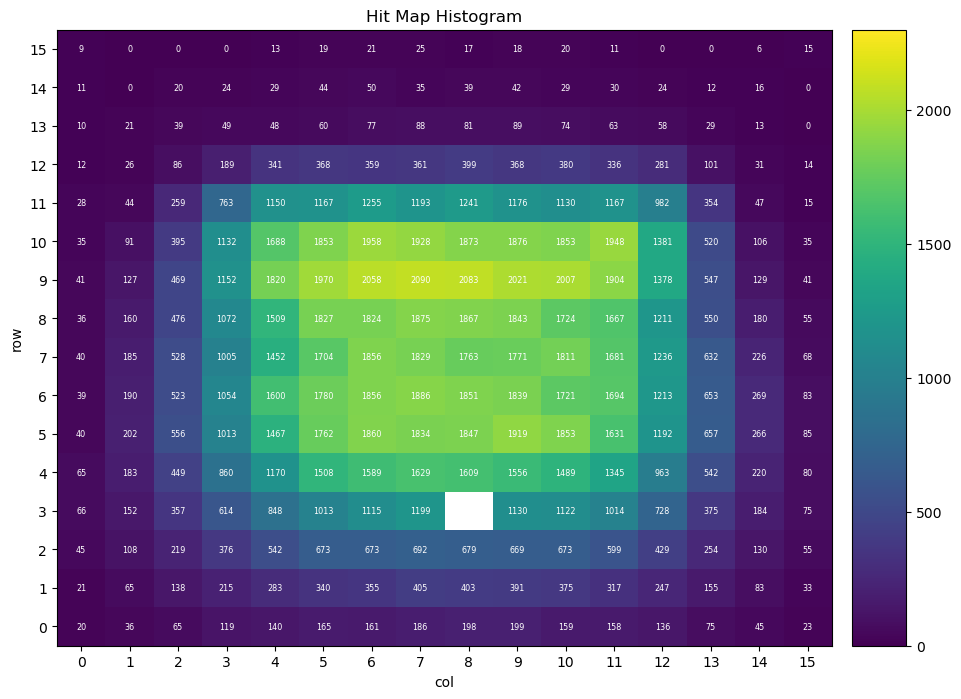

In [2]:
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from os import path
import hist
from hist import Hist
import json
import mplhep
import sys
from scipy.optimize import curve_fit
sys.path.append('/home/users/hswanson13/tbanalysis/') #stupid pytho
from utils import analysis as au

#ANALYZED DATA
data_path = "/home/users/hswanson13/tbanalysis/output_analysis_data/checking_res_nhits/start_5050_stop_5199_bias_260_offset_20.0_energy_5.0_power_i1_file_from_DESY_module_36_LP2_20_cubicLM_unbinned/"
dataPresel = ak.from_parquet(
    path.join(
        data_path, 
        "fullPresel.parquet"
    )
)

#RAW DATA
#data_path = '/ceph/cms/store/user/iareed/ETL/Desy_Mar24'
tele_data_path = '/ceph/cms/store/user/azecchin/DESY_ETROC_telescope_merged/ETROC_Telescope_data/'
run_files = [path.join(tele_data_path,f'Run_5050_5200_{i}.root') for i in range(7)]

def run_chunker(run_list):
    chunk_size=40
    return (run_list[pos:pos+chunk_size] for pos in range(0, len(run_list), chunk_size))

#Hit map
hitmap_hist = Hist(
    #x axis = col
    hist.axis.Integer(0, 16, name="col", label="col", flow=False),
    #y axis = row
    hist.axis.Integer(0, 16, name="row", label="row", flow=False),
)
with open(path.join(data_path, "hit_map.json"), "r") as f:
    hit_map = np.array(json.load(f))

fig, ax = plt.subplots(figsize=(10, 8))
for (row, col), weight in np.ndenumerate(hit_map):
    hitmap_hist.fill(row=row, col=col, weight=weight)
    # x = col, y = row
    ax.text(col + 0.5, row + 0.5, f'{int(weight)}', ha='center', va='center', color='w', fontsize="xx-small")
mplhep.hist2dplot(hitmap_hist, ax=ax, cmax=2300)
ax.set_title('Hit Map Histogram')


In [140]:
nhits_hist = Hist.new.Reg(6,-0.5,5.5, name="nhits").Double()
for chunk in run_chunker(run_files):
    events = uproot.concatenate(chunk)
    nhits = ak.count(events.row, axis=-1)
    nhits_hist.fill(nhits.to_numpy())

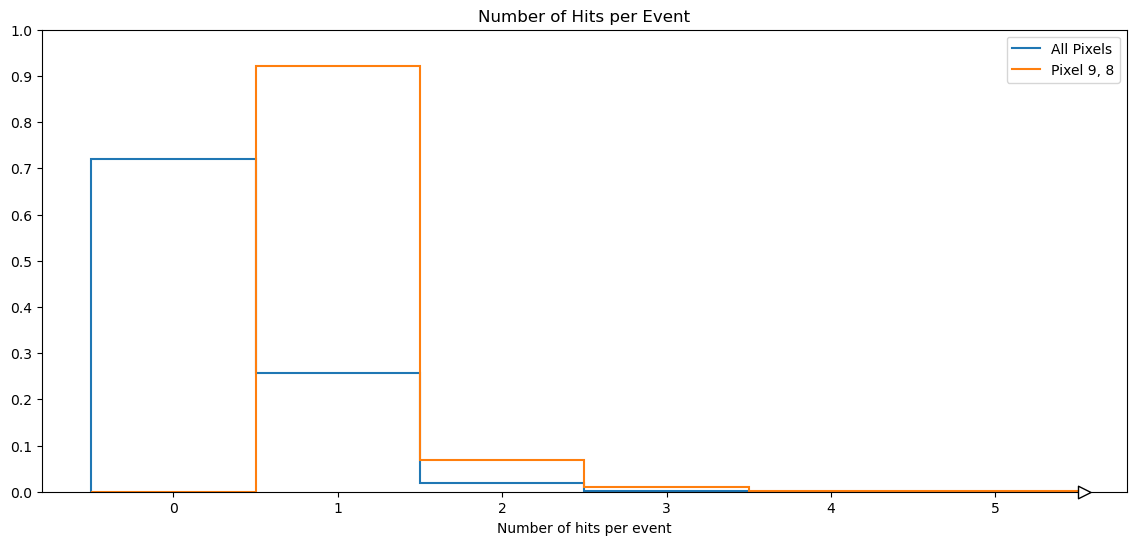

In [146]:
"""
nhits for each event for 1 pixel vs all pixels
"""
fig, ax = plt.subplots(1,1,  figsize=(14, 6))

total_counts = np.sum(nhits_hist.counts())
(nhits_hist/total_counts).plot(ax=ax, label="All Pixels")

row, col = 9, 8
nhits_hist_px = Hist.new.Reg(6, -0.5, 5.5, name="nhits_px", overflow=True).Double()
px_events = dataPresel[ak.any((dataPresel.row==row) & (dataPresel.col==col), axis=-1)]
nhits_hist_px.fill(ak.count(px_events.row, axis=-1))
total_counts = np.sum(nhits_hist_px.counts())
(nhits_hist_px/total_counts).plot(ax=ax, label=f"Pixel 9, 8")

ax.set_xlabel("Number of hits per event")
ax.set_yticks(np.arange(0,1.1,0.1))

ax.set_title("Number of Hits per Event")
ax.legend()


-0.018072289156626523


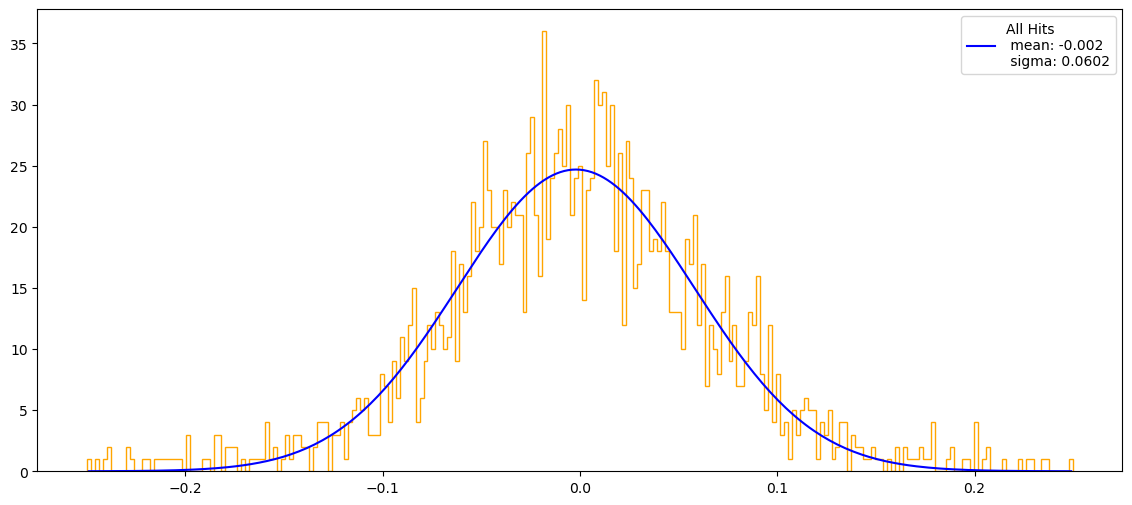

In [6]:
from scipy.optimize import curve_fit

def dt_plot(ax, dts, bins, sigma, colors: tuple, label=''):
    dt_hist, dt_bins = np.histogram(dts, bins)
    bin_centers = (dt_bins[:-1] + dt_bins[1:]) / 2
    ax.hist(dts, bins=dt_bins, color=colors[0], histtype='step')
    
    amplitude = np.max(dt_hist)
    peak_center = bin_centers[dt_hist == amplitude][0]
    print(peak_center)
    gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))
    coeff, _ = curve_fit(gaus, bin_centers, dt_hist, p0=[amplitude, peak_center, sigma])
    ax.plot(
        bin_centers,
        gaus(bin_centers, *coeff),
        color=colors[1],
        label=f'{label}\n mean: {coeff[1]:.3f} \n sigma: {abs(coeff[2]):.4f}',
    )

dt_type = 'dt_corr'
left, right = -.25, .25

# dt_type='dt'
# left, right = 11, 13.5#-10, 25 #
nbins = 75

row, col = 9, 8
hit_cut = 1

#pick any dt with events in row and column, some might be noise
pix_sel = (dataPresel.row==row) & (dataPresel.col==col)
dt = dataPresel[dt_type][ak.any(pix_sel, axis=-1)]

fig, ax = plt.subplots(1,1,  figsize=(14, 6))

# ---------------NORMAL ALL DTS FOR THIS PIXEL CALCULATION--------------------------
dts = ak.flatten(dt)
dt_window = dts[(dts>left) & (dts<right)]
dt_plot(ax, dt_window.to_numpy(), np.linspace(left,right,nbins), 0.1, colors=('orange', 'blue'), label="All Hits")

# --------------CHOSE BASED ON NUMBER OF HITS----------------------------------------
# nhits = ak.count(dt, axis=-1)
# dt_hit_cut = ak.flatten(dt[(nhits > hit_cut)])
# dt_cut_window = dt_hit_cut[(dt_hit_cut>left) & (dt_hit_cut<right)]
# dt_plot(ax, dt_cut_window.to_numpy(), np.linspace(left,right,nbins), 0.1, colors=('red', 'green'), label="nhits > 1")

# --------------Pick the dts closest to the total mean for nhits > 1 -----------------
# mean = 12.538
# dt_with_hits = dt[ak.count(dt, axis=-1) > 0]
# #select only the values close to the peak (superficial track matching)
# min_mask = ak.min(np.abs(dt_with_hits - mean), axis=-1, keepdims=True) == np.abs(dt_with_hits - mean)
# dt_mean_cut = ak.flatten(dt_with_hits[min_mask])
# dt_plot(ax, dt_mean_cut.to_numpy(), np.linspace(left,right,nbins), 0.1, colors=('grey', 'purple'), label="Select Hit Closest to the Mean")

ax.legend()

In [ ]:
#yahist fit explore
from yahist import Hist1D
class Hist1D(Hist1D):
    def __init__(self, *args, **kwargs):
        super(Hist1D, self).__init__(*args, **kwargs)

    def fit(self, fit_method: str, color: str='red'):
        yax = plt.gca()
        if fit_method == 'gaus':
            gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))
        else:
            raise NotImplementedError("Hey sorry this fit method is not implemented, you can add it though :)")
        
        peak_center = self.bin_centers[self.counts == np.max(self.counts)][0]
        amplitude = np.max(self.counts)

        coeff, _ = curve_fit(gaus, self.bin_centers, self.counts, p0=[amplitude, peak_center, 0.1])
        yax.plot(
            self.bin_centers,
            gaus(self.bin_centers, *coeff),
            color="red",
            linewidth=2,
            label='Gaussian Fit\n mean: {:.3f} \n sigma: {:.4f}'.format(coeff[1],abs(coeff[2])),
        )

dt_yahist = Hist1D(dt_window, bins=np.linspace(left,right,300))#f"400,{left},{right}")
dt_yahist.plot(ax, color='orange', label="nhits")
dt_yahist.fit("gaus", color="green")


# MANUAL FITTING WITH YAHIST HISTOGRAM VALUES
# gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))
# coeff, _ = curve_fit(gaus, dt_yahist.bin_centers, dt_yahist.counts, p0=p0)
# ax.plot(
#     dt_yahist.bin_centers,
#     gaus(dt_yahist.bin_centers, *coeff),
#     color="red",
#     linewidth=2,
#     label='Gaussian Fit\n mean: {:.3f} \n sigma: {:.4f}'.format(coeff[1],abs(coeff[2])),
# )


# MANUALLY CHECKING THE dt_hist.fit parameters -> THEY ARE WRONG
# what = dt_yahist.fit("gaus", color="green")
# mean = what['params']['mean']['value']
# sigma = what['params']['sigma']['value']
# N = what['params']['constant']['value']
# coeff = [N, mean, sigma]
# gaus = lambda x, N, mu, sigma: N*np.exp(-(x-mu)**2/(2.0*sigma**2))
# ax.plot(
#     dt_yahist.bin_centers,
#     gaus(dt_yahist.bin_centers, *coeff),
#     color="black",
#     linewidth=5,
#     label='Gaussian Fit\n mean: {:.3f} \n sigma: {:.4f}'.format(coeff[1],abs(coeff[2])),
# )